In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd 
from sklearn.metrics import mean_squared_error as mse
from unidecode import unidecode

import xarray as xr
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Wheat

### 1.1 Read historical wheat data 
- for Argentina on municipality level
- from 1969-2022
- SOURCE: https://datosestimaciones.magyp.gob.ar/

In [8]:
df = (pd
      .read_csv("files/crop data/historical_wheat_data_argentina.csv", encoding="latin-1", sep=";")
      .drop(columns={"Cultivo", "idProvincia", "idDepartamento", "Sup. Sembrada"}))

df.columns = ["year", "province", "municipality", "harvested area [ha]", "production [t]", "yield [kg/ha]"]
df["year"] = df["year"].str[:4].astype(int)

df.head(2)

,year,province,municipality,harvested area [ha],production [t],yield [kg/ha]
0,1969,BUENOS AIRES,25 DE MAYO,42000,71400,1700
1,1970,BUENOS AIRES,25 DE MAYO,36000,54000,1500


### 1.2 Filter relevant provinces

In [9]:
production_by_province = df.groupby("province")["production [t]"].sum().reset_index().sort_values(by="production [t]", ascending=False).reset_index(drop=True)
production_by_province["production cumsum [%]"] = np.round(100 * production_by_province["production [t]"] / df["production [t]"].sum()).cumsum()
production_by_province.head(5)

,province,production [t],production cumsum [%]
0,BUENOS AIRES,359294370,58.0
1,SANTA FE,99172351,74.0
2,CORDOBA,82460626,87.0
3,LA PAMPA,32333143,92.0
4,ENTRE RIOS,28815350,97.0


In [10]:
# Buenos Aires, Santa Fe, Cordoba, Entre Rios, and La Pampa contribute most of Argentinian wheat production. We will only focus on these 5 provinces from now on. 
df = df.loc[df["province"].isin(['BUENOS AIRES', 'CORDOBA', 'ENTRE RIOS', 'LA PAMPA', 'SANTA FE'])].reset_index(drop=True)
# Filter complete time series
df = (df
      [df.groupby(["province", "municipality"])[['province', "municipality"]].transform('size') == len(df["year"].unique().tolist())]
        .reset_index(drop=True))

### 1.3  Preprocess

Preprocessing for original (subnational) wheat yield series

In [11]:
df_subnational = df.copy()
df_subnational["province"] = df_subnational["province"].str.lower().apply(lambda x: unidecode(x))
df_subnational["municipality"] = df_subnational["municipality"].str.lower().apply(lambda x: unidecode(x))
df_subnational["name"] = df_subnational["province"] + " " + df_subnational["municipality"]
df_subnational = df_subnational[["year", "name", "production [t]", "harvested area [ha]", "yield [kg/ha]"]]

df_subnational.head(2)

,year,name,production [t],harvested area [ha],yield [kg/ha]
0,1969,buenos aires 25 de mayo,71400,42000,1700
1,1970,buenos aires 25 de mayo,54000,36000,1500


Aggregation to national level by year, where municipality yield is weighted with harvested area from the municipality.

In [12]:
df_national = df.copy()
df_national["yield weighted"] = df_national["yield [kg/ha]"] * df["harvested area [ha]"]
df_national = df_national.groupby("year").agg({"harvested area [ha]":"sum", "yield weighted":"sum"})
df_national["yield [kg/ha]"] = df_national["yield weighted"] / df_national["harvested area [ha]"]
df_national = df_national[["harvested area [ha]", "yield [kg/ha]"]].reset_index()

df_national.head(2)

,year,harvested area [ha],yield [kg/ha]
0,1969,5058530,1361.123558
1,1970,3553500,1331.921649


### 1.4 Export 

In [13]:
df_national.to_csv("files/crop data/national_yield_with_trend.csv", index=False)
df_subnational.to_csv("files/crop data/subnational_yield_with_trend.csv", index=False)

### 1.5 Detrend national data

Compute trend

In [14]:
def estimate_trend(df):
    # dictionary that stores for each year the slope and bias estimated from the previous years
    years_to_params = {}
    for year in list(range(1993,2023)):
        years_to_params[year] = {"slope":np.nan, "bias":np.nan}
        # from the wheat dataset get the 23 preceding years to the current year, e.g. for year 1993, get 1969-1992
        year_range = df.loc[df["year"].isin(list(range(year-23, year))), ["year", "yield [kg/ha]"]]
        # estimate slope and bias of a linear fit through these preceding years and store them in dictionary
        slope, bias = np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1)
        years_to_params[year]["slope"] = slope
        years_to_params[year]["bias"] = bias
    return years_to_params

In [15]:
years_to_params_national = estimate_trend(df_national)

Filter wheat dataset to study period 1993-2016

In [16]:
df_national_detrended = df_national.loc[df_national["year"].between(1993, 2023)].reset_index(drop=True)

# 2. ERA

### 2.1 Read ERA as GRIB files

The [ERA5-Land monthly averaged Reanalysis-data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview) has been manually downloaded from the copernicus climate change service.

In [60]:
# tmean and LAI 1968-2023
df1 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgid'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 1968 - 2001
df2 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgas'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 2002-2023
df3 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgad'}).to_dataframe().reset_index().dropna().reset_index(drop=True)

rain = pd.concat([df2, df3], ignore_index=True).dropna().reset_index(drop=True)
era = df1.merge(rain, on=["time", "latitude", "longitude", "number", "step", "surface", "valid_time"])

Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file
Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file
Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file


### 2.2 Preprocess ERA

In [61]:
# Kelvin to Celsius
era["t2m"] = era["t2m"].apply(lambda x: x - 273.15)
# time to datetime
era["time"] = pd.to_datetime(era["time"])
era["valid_time"] = pd.to_datetime(era["valid_time"])

era = (era
       .sort_values(by=["time", "latitude", "longitude"])
       .loc[:, ["time", "latitude", "longitude", "t2m", "tp"]]
       .rename(columns={"latitude":"lat", "longitude":"lon", "t2m":"tmean", "tp":"rain"})
       .reset_index(drop=True))

era["month"] = era["time"].dt.month
era["year"] = era["time"].dt.year
era = era.loc[era["month"].between(9,11) & (era["year"].between(1993,2016))].reset_index(drop=True)
era = era[["time", "lat", "lon", "rain", "tmean", "month", "year"]]
era = gpd.GeoDataFrame(era, geometry=gpd.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))

era.head(2)

,time,lat,lon,rain,tmean,month,year,geometry
0,1993-09-01,-42.0,-69.0,0.000550,3.03335,9,1993,POINT (-69.00000 -42.00000)
1,1993-09-01,-42.0,-68.9,0.000521,2.65835,9,1993,POINT (-68.90000 -42.00000)


<Axes: >

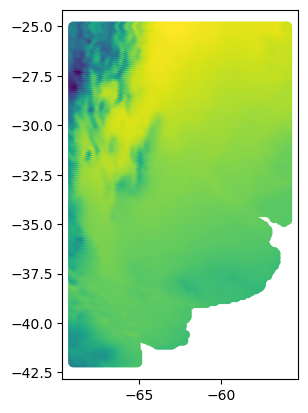

In [66]:
era.dissolve(
     by=["lat", "lon"],
     aggfunc={
         "rain": "mean",
         "tmean": "mean",
     },
 ).plot(column="tmean")

### 2.3 Read Shapefiles and filter relevant wheat cultivating areas

In [20]:
# read subnational wheat series and store unique region names
relevant_areas = pd.read_csv("files/crop data/subnational_yield_with_trend.csv")["name"].unique()

# Read ADM2 shapefiles (municipality level) and filter by relevant states
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES"] + " " + gdf_adm2["ADM2_ES"]

# Read ADM1 shapefiles
gdf_adm1 = gpd.read_file("files/shapefiles/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")

# filter areas 
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_areas), ["name", "geometry"]].reset_index(drop=True)
gdf_adm2.head(2)

,name,geometry
0,buenos aires tres arroyos,"POLYGON Z ((-60.16947 -38.17843 0.00000, -60.0..."
1,buenos aires general pinto,"POLYGON Z ((-61.98441 -34.51765 0.00000, -61.8..."


### 2.4 Filter ERA by coordinates

In [21]:
# directly spatial join takes too much time
coordinates = gpd.sjoin(era[["geometry", "lat", "lon"]].drop_duplicates(), gdf_adm2).reset_index(drop=True)[["name", "lat", "lon"]]
era = era.merge(coordinates[["lat", "lon", "name"]], on=["lat", "lon"], how="right")

# aggregate era across municipality (=name)
era = era.groupby(["name", "time", "year", "month"]).agg({"rain":"mean", "tmean":"mean"}).reset_index()
era.head(2)

,name,time,year,month,rain,tmean
0,buenos aires 25 de mayo,1993-09-01,1993,9,0.003672,11.504344
1,buenos aires 25 de mayo,1993-10-01,1993,10,0.004624,15.942628


Check if all went well

<Axes: >

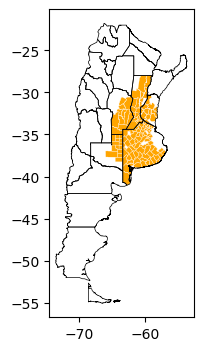

In [22]:
base = gdf_adm2.loc[gdf_adm2["name"].isin(era["name"].unique())].plot(figsize=(4,4), color="orange", edgecolor="white", linewidth=.2)
gdf_adm1.plot(ax=base, color="#FF000000", edgecolor="black", linewidth=0.5)

### 2.5 Restructure dataset

In [23]:
era_features = era.pivot(index="year", columns=["name", "month"], values=["rain", "tmean"])
era_features.columns = ["{}_{}_{}".format(s[0],s[1],s[2]) for s in era_features.columns]
era_features = era_features.reset_index()
era_features.head()

,year,rain_buenos aires 25 de mayo_9,rain_buenos aires 25 de mayo_10,rain_buenos aires 25 de mayo_11,rain_buenos aires 9 de julio_9,rain_buenos aires 9 de julio_10,rain_buenos aires 9 de julio_11,rain_buenos aires adolfo alsina_9,rain_buenos aires adolfo alsina_10,rain_buenos aires adolfo alsina_11,...,tmean_santa fe san justo_11,tmean_santa fe san lorenzo_9,tmean_santa fe san lorenzo_10,tmean_santa fe san lorenzo_11,tmean_santa fe san martin_9,tmean_santa fe san martin_10,tmean_santa fe san martin_11,tmean_santa fe vera_9,tmean_santa fe vera_10,tmean_santa fe vera_11
0,1993,0.003672,0.004624,0.005893,0.003883,0.004158,0.006154,0.001277,0.002418,0.005371,...,20.987172,13.181299,17.686621,19.747070,13.869561,18.270352,20.244004,16.723047,20.544873,21.863350
1,1994,0.004834,0.002982,0.001956,0.002992,0.002993,0.001888,0.000614,0.002181,0.001818,...,21.844978,15.849854,17.330029,21.368066,16.644229,18.007529,21.269316,19.528076,20.530674,22.216523
2,1995,0.000535,0.002790,0.001777,0.000537,0.002799,0.002493,0.000382,0.001937,0.003436,...,23.485742,16.013330,17.024316,21.444287,16.618955,17.346777,22.001201,18.648125,19.918408,25.476445
3,1996,0.001618,0.003890,0.004558,0.001404,0.003781,0.003973,0.000740,0.002251,0.004578,...,22.955329,14.559570,18.583643,21.834033,14.714336,18.796045,22.390439,17.608613,20.811484,23.387070
4,1997,0.001301,0.005324,0.005031,0.001263,0.005907,0.004336,0.001579,0.003742,0.002059,...,22.493659,15.282617,17.721826,20.458887,16.177031,18.135732,20.880957,19.520986,20.985488,23.198037


In [24]:
era_features.to_csv("files/ERA/processed/era_tmean_rain_all_departments.csv", index=False)

### 2.6 Basis Expansion

In [25]:
def standardize_loyo(data):
    data = data.copy()
    standardized_data = []
    for year in list(range(1993, 2017)):
        # split
        features_used_for_standardization = data.loc[data["year"] != year, [c for c in data.columns if c != "year"]].reset_index(drop=True).copy()
        features_to_standardize = data.loc[(data["year"] == year), [c for c in data.columns if c != "year"]].reset_index(drop=True).copy()
        # standardize
        features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
        # bring it together
        year = data.loc[(data["year"] == year), ["year"]].reset_index(drop=True)
        standardized_df = pd.concat([year, features_standardized], axis=1)
        standardized_data.append(standardized_df)
    df_standardized = pd.concat(standardized_data, ignore_index=True)
    return df_standardized

def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(data)
    
    # store features and target in variables for better readability
    X_temp = df_standardized.loc[:, [c for c in df_standardized.columns if ("tmean" in c)]]
    X_rain = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" in c)]]
    y = df_standardized.loc[:, ["year"]].reset_index(drop=True)
    
    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain * X_temp.values
    X_tmean_squared.columns = ["tmeansquared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rainsquared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmeanrain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True))
    data_expanded = pd.concat([y, X], axis=1)

    # standardize expanded features again
    df_standardized = standardize_loyo(data_expanded)
    
    return df_standardized

In [26]:
era_basis_expansion = apply_basis_expansion(era_features)
era_basis_expansion.head(2)

,year,tmeansquared_buenos aires 25 de mayo_9,tmeansquared_buenos aires 25 de mayo_10,tmeansquared_buenos aires 25 de mayo_11,tmeansquared_buenos aires 9 de julio_9,tmeansquared_buenos aires 9 de julio_10,tmeansquared_buenos aires 9 de julio_11,tmeansquared_buenos aires adolfo alsina_9,tmeansquared_buenos aires adolfo alsina_10,tmeansquared_buenos aires adolfo alsina_11,...,tmeanrain_santa fe san justo_11,tmeanrain_santa fe san lorenzo_9,tmeanrain_santa fe san lorenzo_10,tmeanrain_santa fe san lorenzo_11,tmeanrain_santa fe san martin_9,tmeanrain_santa fe san martin_10,tmeanrain_santa fe san martin_11,tmeanrain_santa fe vera_9,tmeanrain_santa fe vera_10,tmeanrain_santa fe vera_11
0,1993,1.420914,-0.759344,-0.111418,1.650211,-0.681814,0.048171,-0.865437,-0.416741,0.433436,...,-1.042311,1.285535,-2.187527,-0.110478,0.905252,-2.511513,-0.009291,-0.176854,-0.882908,-0.522672
1,1994,-0.745486,0.285874,-0.499296,-0.713366,0.162838,-0.521486,-1.004409,-0.051197,-0.206265,...,0.355199,0.317717,0.347394,0.130898,-0.695378,-0.738003,0.676131,0.631222,-0.332272,-0.112972


### 2.7 EXPORT

In [27]:
era_basis_expansion.to_csv("files/ERA/processed/era_basis_expansion_all_departments.csv", index=False)

# 3. Visualize

Read shapefiles to create figure for introduction

In [37]:
# read subnational wheat series and store unique region names
relevant_areas = df_subnational["name"].unique()

# Read ADM2 shapefiles (municipality level) and filter by relevant states
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES"] + " " + gdf_adm2["ADM2_ES"]

# filter areas 
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_areas), ["name", "geometry"]].reset_index(drop=True)
gdf_adm2 = gdf_adm2.merge(era.groupby("name")[["rain", "tmean"]].mean().reset_index(), on="name")

Apply detrending with dictionary and plot figure

372.6


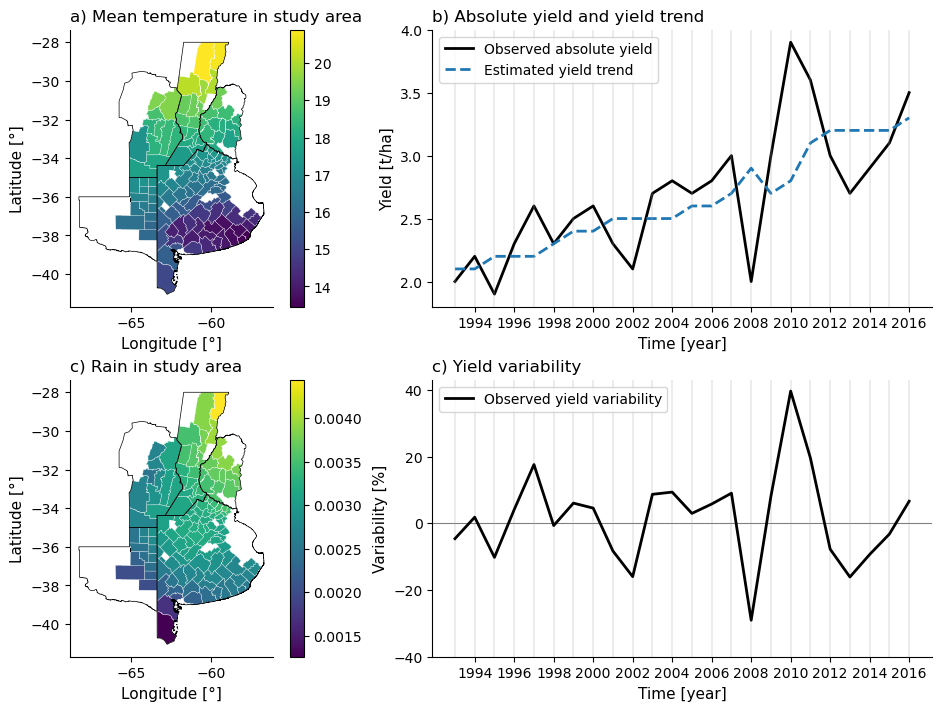

In [52]:
# Create subplots
fig, axd = plt.subplot_mosaic([['upper left', 'upper right'],
                               ['lower left', 'lower right']],
                              figsize=(10, 7), layout="constrained", width_ratios=[0.4, 0.6])

# Figure a) Study region - Tmean
gdf_adm1 = gpd.read_file("files/shapefiles/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")
gdf_adm1 = gdf_adm1.loc[gdf_adm1["ADM1_ES"].isin(['Buenos Aires', 'Córdoba', 'Entre Ríos', 'La Pampa', 'Santa Fe'])].reset_index(drop=True)
gdf_adm2.plot(ax=axd["upper left"], column="tmean", edgecolor="white", linewidth=.2, legend=True)
gdf_adm1.plot(ax=axd["upper left"], color="#FF000000", edgecolor="black", linewidth=0.5)
axd['upper left'].set_title("a) Mean temperature in study area", loc="left", size=12);
axd['upper left'].set_ylabel("Latitude [°]", size=11);
axd['upper left'].set_xlabel("Longitude [°]", size=11);
axd['upper left'].spines[['right', 'top']].set_visible(False)

# Figure c) Study region - Rain
gdf_adm2.plot(ax=axd["lower left"], column="rain", edgecolor="white", linewidth=.2, legend=True)
gdf_adm1.plot(ax=axd["lower left"], color="#FF000000", edgecolor="black", linewidth=0.5)
axd['lower left'].set_title("c) Rain in study area", loc="left", size=12);
axd['lower left'].set_ylabel("Latitude [°]", size=11);
axd['lower left'].set_xlabel("Longitude [°]", size=11);
axd['lower left'].spines[['right', 'top']].set_visible(False)

# Preprocessing for trend plot
trend_estimated = []
relevant_years = list(range(1993, 2022))
for year in relevant_years:
    value = year * years_to_params_national[year]["slope"] + years_to_params_national[year]["bias"]
    trend_estimated.append(value)

# Figure b) Absolute yield and trend
trend_estimates_t_ha = [np.round(x/1000, 1) for x in trend_estimated]
absolute_yield_t_ha = [np.round(x/1000, 1) for x in df_national_detrended["yield [kg/ha]"].values.tolist()]
axd['upper right'].plot(relevant_years[:-5], absolute_yield_t_ha[:-5], label="Observed absolute yield", color="black", linewidth=2)
axd['upper right'].plot(relevant_years[:-5], trend_estimates_t_ha[:-5], label="Estimated yield trend", linewidth=2, linestyle="dashed")
axd['upper right'].set_title("b) Absolute yield and yield trend", loc="left", size=12)
axd['upper right'].set_ylabel("Yield [t/ha]", size=11)
axd['upper right'].set_xlabel("Time [year]", size=11)
axd['upper right'].set_xticks(list(range(1994, 2017, 2)))
xcoords = list(range(1993, 2016, 2))
for xc in xcoords:
    axd['upper right'].axvline(x=xc, linewidth=.3, color="#A8A8A8")
axd['upper right'].grid(axis="x", linewidth=.3, color="#A8A8A8")
axd['upper right'].set_yticks([4, 3.5, 3, 2.5, 2])
axd['upper right'].spines[['right', 'top']].set_visible(False)
axd['upper right'].legend()

# print RMSE of trend estimation
print(np.round(mse(trend_estimated, df_national_detrended["yield [kg/ha]"].values.tolist(), squared=False), 2))

# Detrending
df_national_detrended["yield_trend [kg/ha]"] = trend_estimated
df_national_detrended["yield anomaly [%]"] = (df_national_detrended["yield [kg/ha]"] - df_national_detrended["yield_trend [kg/ha]"]) / df_national_detrended["yield_trend [kg/ha]"]

# Figure d) Detrended yield
axd['lower right'].axhline(0, 0, color="grey", linewidth=.8)
xcoords = list(range(1993, 2016, 2))
for xc in xcoords:
    axd['lower right'].axvline(x=xc, linewidth=.3, color="#A8A8A8")
axd['lower right'].plot(df_national_detrended["year"][:-5], 100 * df_national_detrended["yield anomaly [%]"][:-5], color="black", linewidth=2, label="Observed yield variability")
axd['lower right'].set_title("c) Yield variability", loc="left", size=12)
axd['lower right'].set_ylabel("Variability [%]", size=11)
axd['lower right'].set_xlabel("Time [year]", size=11)
axd['lower right'].set_xticks(list(range(1994, 2017, 2)))
axd['lower right'].grid(axis="x", linewidth=.3, color="#A8A8A8")
axd['lower right'].set_yticks([40, 20, 0, -20, -40])
axd['lower right'].spines[['right', 'top']].set_visible(False)
axd['lower right'].legend(loc="upper left")

#plt.savefig("figures/figure1.svg")

### 6. Export detrended yield dataset

In [18]:
df_national_detrended.to_csv("data/crop/national_yield_detrended.csv", index=False) # 1993-2021